# Deep Recommender: Basic Matrix Factorization

This notebook is a toy implementation of a product recommendation system that uses matrix factorization. Its main purpose is to demonstrate that deep learning methods can approximate traditional SVD/SGD-based factorization.

### Use Case
We have a fixed number of users and items (products). For some user-item pairs we know the interaction score (e.g. user rating). No additional user or item features or score metadata (e.g. time stamps) are available. Our goal is to estimate the scores for the remaining user-item pairs. 

### Prototype: Approach and Data
We first implement and evaluate the stochastic gradient descent (SGD) algorithm. It is an alternative to algebraic factorization using singular value decomposition (SVD), but it properly handles missed values in the rating matrix and simplifies large-scale computations due to its iterative nature. 

Second, we implement basically the same factorization using a simple neural network. SVD- and SGD-based factorization are equivalent to finding low-dimensional user and item embeddings, and predicting ratings as their product. We implement the same approach using Embedding and Dot layers in Keras.

The notebook uses only a small 10x10 rating matrix defined inline. No external datasets are used.

### Usage and Productization
This prototype is intended mainly for educational purposes and evaluations of small datasets. Prototyping using real-world data samples and production solution should use more scalable implementations.

In [ ]:
#
# Imports and settings
#
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
plt.rcParams.update({'pdf.fonttype': 'truetype'})

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Input, Concatenate, Embedding, Dot

Rating density is 63.00%


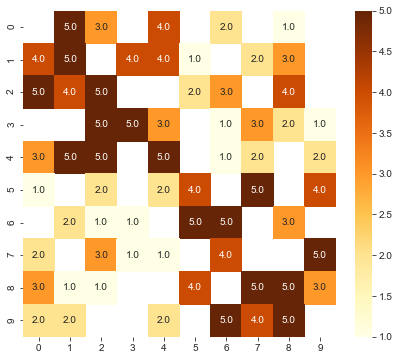

In [6]:
#
# Let us assume two categories of products, bakery and fruits,
# and two categories of users, bakery-lovers and fruit-lovers.
# For simplicity of visualization, we define a rating matrix 
# with 4 blocks, but users and items can be arbitrary 
# permuted, of course.
#
_ = np.nan
R = [[_, 5, 3, _, 4, _, 2, _, 1, _], #
     [4, 5, _, 4, 4, 1, _, 2, 3, _], #
     [5, 4, 5, _, _, 2, 3, _, 4, _], # bakery-lovers
     [_, _, 5, 5, 3, _, 1, 3, 2, 1], #
     [3, 5, 5, _, 5, _, 1, 2, _, 2], # _____________
     [1, _, 2, _, 2, 4, _, 5, _, 4], # 
     [_, 2, 1, 1, _, 5, 5, _, 3, _], # 
     [2, _, 3, 1, 1, _, 4, _, _, 5], # fruit-lovers
     [3, 1, 1, _, _, 4, _, 5, 5, 3], #
     [2, 2, _, _, 2, _, 5, 4, 5, _]] #
    #|             |              |
    #|    bakery   |    fruits    |  
    #|   products  |              |  

R = np.array(R)

fig, ax = plt.subplots(1, figsize=(7, 6))
sns.heatmap(R, ax=ax, annot=True, fmt=".1f", cmap="YlOrBr");

# Measure rating sparsity
def density(R):
    nan_count = np.count_nonzero(~np.isnan(R))
    density = nan_count / (R.shape[0] * R.shape[1]) * 100
    print(f'Rating density is {density:.2f}%')
density(R)

In [7]:
#
# Helper functions
#
def normalize(x):
    return (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))

def denormalize(x, min_val, max_val):
    return (x * (max_val - min_val)) + min_val 

# Convert user-item matrix into an array of samples (user_id, item_id, rating)
def matrix_to_samples(R):
    x = []
    for u in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[u, j]):
                x.append([u, j, R[u, j]])
    return np.array(x)

# Factorization Using SGD

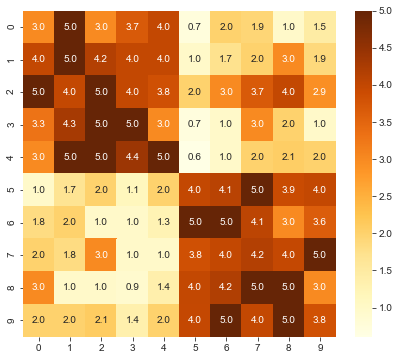

In [8]:
R_norm = normalize(R)
x = matrix_to_samples(R_norm)

def predict_rating(P, Q, u, j):
    return np.dot(P[:, u].T, Q[:, j])

def fit_sgd(x, k, n_epochs = 500, learning_rate = 0.01, lambda_coeff = 0.05):
    n_users, n_items = len(np.unique(x[:, 0])), len(np.unique(x[:, 1]))

    P = np.random.rand(k, n_users)
    Q = np.random.rand(k, n_items)

    for epoch in range(n_epochs):
        for u, j, r in x:
            u, j = int(u), int(j)
            error = r - predict_rating(P, Q, u, j)
            P[:, u] += learning_rate * (error * Q[:, j] - lambda_coeff * P[:, u])
            Q[:, j] += learning_rate * (error * P[:, u] - lambda_coeff * Q[:, j])
            
    return P, Q

embedding_dim = 2

P, Q = fit_sgd(x, embedding_dim)

#
# Fill-in the missed ratings using the factor model
#
R_hat = R.copy()
for u in range(R.shape[0]):
    for j in range(R.shape[1]):
        if np.isnan(R[u, j]):
            R_hat[u, j] = denormalize(predict_rating(P, Q, u, j), np.nanmin(R), np.nanmax(R))
            
fig, ax = plt.subplots(1, figsize=(7, 6))
sns.heatmap(R_hat, ax=ax, annot=True, fmt=".1f", cmap="YlOrBr");

The above factorization clearly captures and reconstructs the 4-block pattern.

# Factorization Using Neural Networks

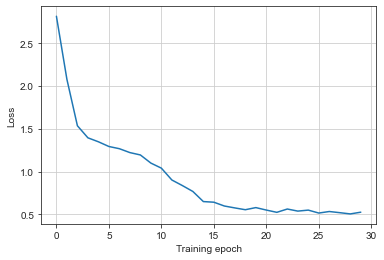

In [9]:
R_norm = R
xy = matrix_to_samples(R_norm)
x1, x2, y = xy[:, 0].astype(int), xy[:, 1].astype(int), xy[:, 2]

n_users, n_items = R.shape
embedding_dim = 2

input_user = Input(shape=(1,))
input_item = Input(shape=(1,))

embedding_user = Embedding(input_dim=n_users, output_dim=embedding_dim)(input_user)
embedding_item = Embedding(input_dim=n_items, output_dim=embedding_dim)(input_item)

combined = Dot(axes=2)([embedding_user, embedding_item])

score = Dense(1, activation='linear')(combined)

model = Model(inputs=[input_user, input_item], outputs=score)

#
# Model training
#
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_absolute_error') 
history = model.fit([x1, x2], y, batch_size=1, epochs=30, verbose=0, validation_data=([x1, x2], y)) 

plt.plot(history.history['loss']);
plt.xlabel('Training epoch')
plt.ylabel('Loss')
plt.grid(True)

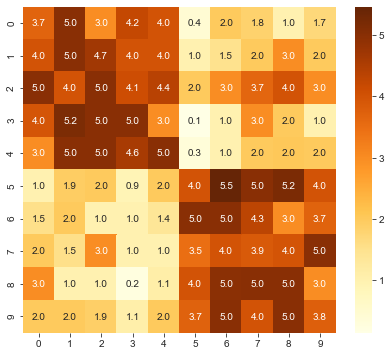

In [10]:
#
# Fill-in the missed ratings using the Keras model
#
R_hat = R.copy()
for u in range(R.shape[0]):
    for j in range(R.shape[1]):
        if np.isnan(R[u, j]):
            R_hat[u, j] = model.predict([np.array([u]), np.array([j])])
            
fig, ax = plt.subplots(1, figsize=(7, 6))
sns.heatmap(R_hat, ax=ax, annot=True, fmt=".1f", cmap="YlOrBr");

The Keras-based factorization also captures and reconstructs the 4-block pattern.